<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/DHOD/blob/u%2FEiffL%2Foptimization/nb/Optimized_HOD_HMC_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling HOD parameters by Hamiltonian Monte-Carlo

Authors:
 - [@bhorowitz](https://github.com/bhorowitz) (Ben Horowitz)
 - [@EiffL](https://github.com/EiffL) (Francois Lanusse)


This notebook demonstrate sampling HOD parameters using HMC over a stochastically sampled galaxy catalogs.




## Setup

Here we quickly install our dependencies, and download the reference halotools 
catalog from the Bolshoi simulation. This takes under a minute.

In [23]:
!pip install --quiet -i https://test.pypi.org/simple/ halotools
!pip install --quiet corner
!pip install --quiet git+https://github.com/DifferentiableUniverseInitiative/DHOD.git@u/EiffL/optimization

In [ ]:
!download_initial_halocat.py

In [1]:
%pylab inline
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory
from halotools.mock_observables.two_point_clustering import tpcf
from halotools.mock_observables import return_xyz_formatted_array

Populating the interactive namespace from numpy and matplotlib


In [2]:
import tensorflow as tf
import edward2 as ed
from diffhod.components import Zheng07Cens, Zheng07Sats, NFWProfile
from diffhod.utils import cic_paint
from diffhod.mock_observables.pk import Power_Spectrum

In [3]:
# A few hyper parameters
temperature=0.02
batch_size=2
box_size = 250.

fid_params = tf.convert_to_tensor([12.02, 0.26, 11.38, 13.31, 1.06])

Total size of halo catalog 159184
Size of low mass halo catalog 157632
Size of high mass halo catalog 1552


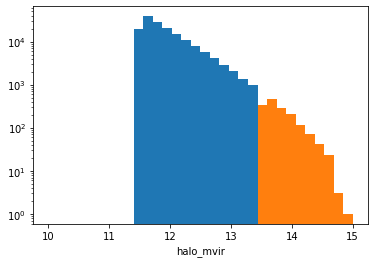

In [4]:
# Load a reference halo catalog
halocat = CachedHaloCatalog(simname = 'bolshoi', redshift=0.) 

# Removing subhalos, and restricting the size of the catalog
halo_table = halocat.halo_table
halo_table = halo_table[halo_table['halo_pid'] == -1]
halo_table = halo_table[halo_table['halo_x'] < box_size]
halo_table = halo_table[halo_table['halo_y'] < box_size]
halo_table = halo_table[halo_table['halo_z'] < box_size]
halo_table = halo_table[np.log10(halo_table['halo_mvir']) >= 11.5]
print("Total size of halo catalog", len(halo_table))

# Split the catalog into low and high mass halo
low_mass_table = halo_table[np.log10(halo_table['halo_mvir']) < 13.5]
high_mass_table = halo_table[np.log10(halo_table['halo_mvir']) >= 13.5]

# Convert table to tensors
tf_halocat_low = {k: tf.convert_to_tensor(low_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}
tf_halocat_high = {k: tf.convert_to_tensor(high_mass_table[k], dtype=tf.float32) for k in halo_table.colnames}

hist(log10(low_mass_table['halo_mvir']),32, range=[10,15]);
hist(log10(high_mass_table['halo_mvir']),32, range=[10,15]);
yscale('log')
xlabel('halo_mvir');
print("Size of low mass halo catalog", len(low_mass_table))
print("Size of high mass halo catalog", len(high_mass_table));

In [5]:
# Here is how we define the same model in
def hod(halo_cat, 
        logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
        max_sat=20):
  
  ### Occupation model ###
  n_cen = Zheng07Cens(halo_cat['halo_mvir'],
                      sigma_logM=sigma_logM,
                      logMmin=logMmin,
                      temperature=temperature)
  
  n_sat = Zheng07Sats(halo_cat['halo_mvir'],
                      n_cen,
                      logM0=logM0,
                      logM1=logM1,
                      alpha=alpha,
                      sample_shape=(max_sat,),
                      temperature=temperature)
  
  ### Phase Space model ###
  # Centrals are just located at center of halo
  pos_cen = ed.Deterministic(tf.stack([halo_cat['halo_x'],
                                       halo_cat['halo_y'],
                                       halo_cat['halo_z']], axis=-1))

  # Satellites follow an NFW profile centered on halos
  pos_sat = NFWProfile(pos=pos_cen,
                       concentration=halo_cat['halo_nfw_conc'],
                       Rvir=halo_cat['halo_rvir'],
                       sample_shape=(max_sat, batch_size))
  
  return {'pos_cen':pos_cen,'n_cen':n_cen, 'pos_sat':pos_sat, 'n_sat':n_sat}

In [6]:
def paint_galaxies(gal_cat, nc=128, rho=None):
  """ Function that paints galaxies on the field
  """
  # Take centrals and rescale them to the boxsize
  bs = gal_cat['n_sat'].shape[1]

  # Convert to mesh pixel coordinate
  sample1 = gal_cat['pos_cen'] / box_size * nc
  weights1 = gal_cat['n_cen']
  sample1_r = tf.tile(tf.expand_dims(sample1,0),[bs,1,1])

  # Take sats and rescale them to the boxize
  sample2 = gal_cat['pos_sat'] / box_size * nc
  weights2 = gal_cat['n_sat']
  # Swapping sample dimension and batch dimension
  sample2 = tf.transpose(sample2, [1,0,2,3])
  weights2 = tf.transpose(weights2, [1,0,2])
  # Reshaping
  sample2 = tf.reshape(sample2, [bs, -1, 3])
  weights2 = tf.reshape(weights2, [bs, -1])
  
  if rho is None:
    rho = tf.zeros((bs, nc, nc, nc))

  rho = cic_paint(rho,sample1_r, weights1)
  rho = cic_paint(rho, sample2, weights2)
  return rho

In [7]:
# Let's now build a function that returns a sampled power spectrum
PS = Power_Spectrum(shape=np.array([128, 128, 128]).astype('int32'), 
               boxsize=np.array([box_size, box_size, box_size]),
               kmin=0.1,dk=.05)

@tf.function
def get_pk(logMmin=12.02, sigma_logM=0.26, logM0=11.38, logM1=13.31, alpha=1.06,
           max_sat_low=20, max_sat_high=200):
  """ This function samples the catalogs, paint the galaxies, and compute the 
  power spectrum
  """
  # Sample and paint galaxies low mass halos
  rho = paint_galaxies(hod(tf_halocat_low, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_low))
  
  # Add galaxies from high mass halos
  rho = paint_galaxies(hod(tf_halocat_high, logMmin, sigma_logM, logM0, logM1, alpha,
                           max_sat=max_sat_high),
                       rho=rho)
  
  # Compute power spectrum of resulting field
  k, pk = PS.pk_tf(rho)
  return k, pk

In [8]:
# Let's just compute the covariance, we will run 2000 simulations at fiducial parameters
# This takes 2 minutes
import time
start_time = time.time()
samps = []
for i in range(1000):
  k, pk = get_pk(logMmin=12.02*tf.ones([batch_size]),
                sigma_logM=0.26*tf.ones([batch_size]), 
                logM0=11.38*tf.ones([batch_size]), 
                logM1=13.31*tf.ones([batch_size]), 
                alpha=1.06*tf.ones([batch_size]))
  samps.append(pk)
end_time = time.time()- start_time
print(end_time)

Instructions for updating:
Use fn_output_signature instead
567.3049743175507


In [9]:
samps = np.stack(samps, axis=0).reshape(2000,-1)
klim = (k < 1).numpy()
diag_std = samps.std(axis=0)[klim]
mean = samps.mean(axis=0)[klim]
cov = np.cov(samps[:,klim].T)
fake_data = samps[0,klim]

In [10]:
# ading some measurement errors on the power spectrum
# cov = cov + 0.0001**2*np.eye(len(cov))

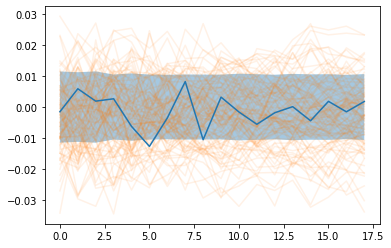

In [11]:
for i in range(100):
    plot(samps[i][klim]/mean - 1, color='C1', alpha=0.1)
plot(fake_data/mean - 1)
fill_between(arange(len(mean)), -diag_std/mean, diag_std/mean, alpha=0.4)

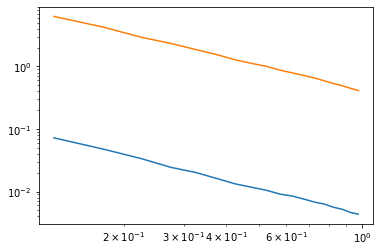

In [12]:
#loglog(k, diag_std)
#loglog(k, diag_std*0+0.001)
loglog(k[klim], np.sqrt(np.diag(cov)))
loglog(k[klim], mean)

In [13]:
f_hartlap = (float(2000) - float(mean.shape[0]) -2.)/(float(2000) - 1.)
cinv_pk = np.linalg.inv(cov)

In [14]:
f_hartlap

0.9904952476238119

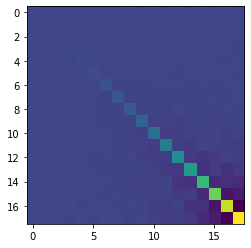

In [17]:
imshow(cinv_pk)

In [32]:
# This is not the right way to do this with edward, but...
import tensorflow_probability as tfp 
tfd = tfp.distributions

p = tf.tile(tf.expand_dims(fid_params,0), [batch_size, 1])

@tf.function
def log_prob_fn(params):
  print(params)
  k, pk = get_pk(logMmin=params[:,0],
              sigma_logM=params[:,1], 
              logM0=params[:,2], 
              logM1=params[:,3], 
              alpha=params[:,4])
  pk = pk[:,:18]
  return tfd.MultivariateNormalFullCovariance(loc=fake_data, covariance_matrix=cov.astype('float32')).log_prob(pk)

In [33]:
# I mean... ok, let's try with emcee

In [34]:
import emcee

In [35]:
theta_fid = np.array([12.02, 0.26, 11.38, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb


theta_off = np.array([12.02, 0.46, 11.58, 13.31, 1.06]) # value from https://github.com/DifferentiableUniverseInitiative/DHOD/blob/batch_hmc/nb/batch_hod-hmc-overview.ipynb

In [36]:
# 32 walkers
pos = theta_off + 1e-4 * np.random.randn(16, theta_fid.shape[0])
nwalkers, ndim = pos.shape

In [37]:
filename = "test3.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

In [38]:
log_prob_fn(p)

Tensor("params:0", shape=(2, 5), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([53.102867, 60.55983 ], dtype=float32)>

In [39]:
num_burnin_steps = int(0) #oops....
num_chains = batch_size

#tfp.mcmc.SimpleStepSizeAdaptation(
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=log_prob_fn,
        num_leapfrog_steps=3,
        step_size=1e-5)#, #can play a lot with this number...
#    num_adaptation_steps=int(num_burnin_steps * 0.8))

In [40]:
#start spread out around some point
var = (np.random.random([num_chains, 5])-0.5)*np.array([0.1,0.02,0.01,0.1,0.01])*10

In [41]:
num_results = 10

# Initial state of the chain
init_state = tf.Variable(np.ones([num_chains, 5], dtype=dtype)*fid_params+var,dtype=float32)

In [42]:
init_state

<tf.Variable 'Variable:0' shape=(2, 5) dtype=float32, numpy=
array([[12.43496   ,  0.35567623, 11.408462  , 12.923724  ,  1.0153404 ],
       [12.217952  ,  0.23557885, 11.348635  , 13.105139  ,  1.0201018 ]],
      dtype=float32)>

In [43]:
@tf.function
def run_chain():
    samples, trace = tfp.mcmc.sample_chain(
      num_results=num_results,
      current_state=init_state,
      kernel=adaptive_hmc)
    return samples, trace

In [44]:
import time
current_time = time.time()
q,is_accepted = run_chain()
run_time = time.time()-current_time
print(run_time)

Tensor("params:0", shape=(2, 5), dtype=float32)


/local/home/flanusse/.local/lib/python3.8/site-packages/tensorflow_probability/python/mcmc/sample.py:342: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


40.37465453147888


In [45]:
is_accepted.is_accepted

<tf.Tensor: shape=(10, 2), dtype=bool, numpy=
array([[False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]])>

In [61]:
init_state

<tf.Variable 'Variable:0' shape=(2, 5) dtype=float32, numpy=
array([[12.020327  ,  0.2599496 , 11.380009  , 13.309808  ,  1.0599847 ],
       [12.020145  ,  0.26000974, 11.379963  , 13.309797  ,  1.0600109 ]],
      dtype=float32)>

In [49]:
q.shape

TensorShape([10, 2, 5])

In [24]:
import corner

In [136]:
is_accepted

MetropolisHastingsKernelResults(
  accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction=<tf.Tensor: shape=(100, 2), dtype=float32, numpy=
        array([[-1.1742115e-04,  0.0000000e+00],
               [ 7.6341629e-04,  0.0000000e+00],
               [ 7.6341629e-04,  0.0000000e+00],
               [ 7.6341629e-04,  0.0000000e+00],
               [ 7.6341629e-04,  0.0000000e+00],
               [ 7.6341629e-04,  6.9266558e-04],
               [ 7.6341629e-04, -2.5796890e-04],
               [ 7.6341629e-04, -2.3365021e-04],
               [ 7.6341629e-04, -2.3365021e-04],
               [ 7.6341629e-04, -2.3365021e-04],
               [-2.7360916e-03, -1.6069412e-04],
               [-2.7360916e-03, -1.6069412e-04],
               [-2.7360916e-03, -1.6069412e-04],
               [-2.7360916e-03, -1.6069412e-04],
               [-2.7360916e-03, -1.6069412e-04],
               [-2.7360916e-03, -1.6069412e-04],
               [-2.7360916e-03, -1

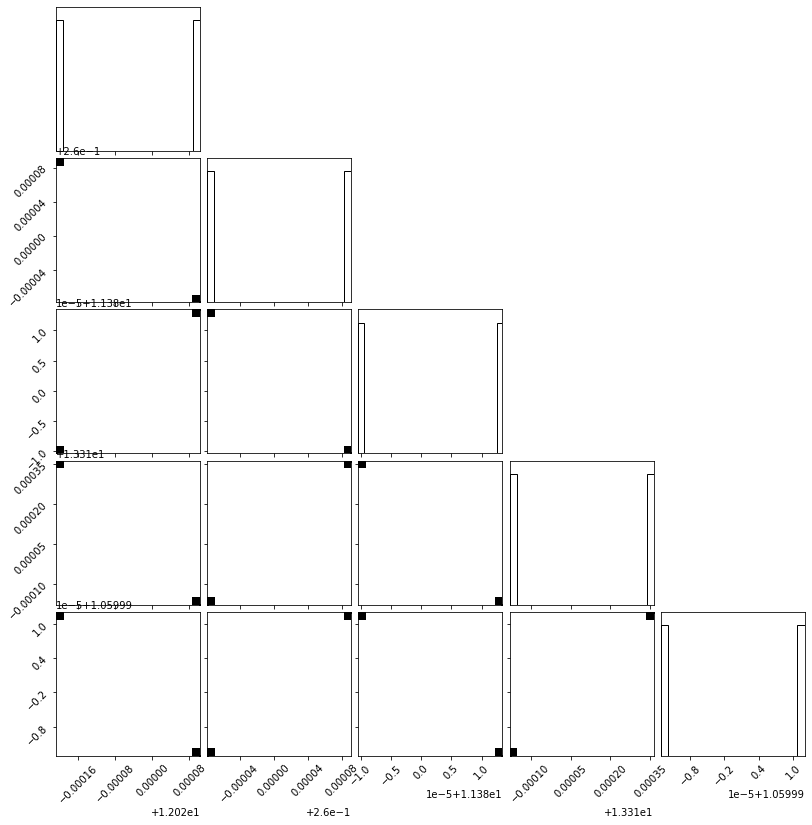

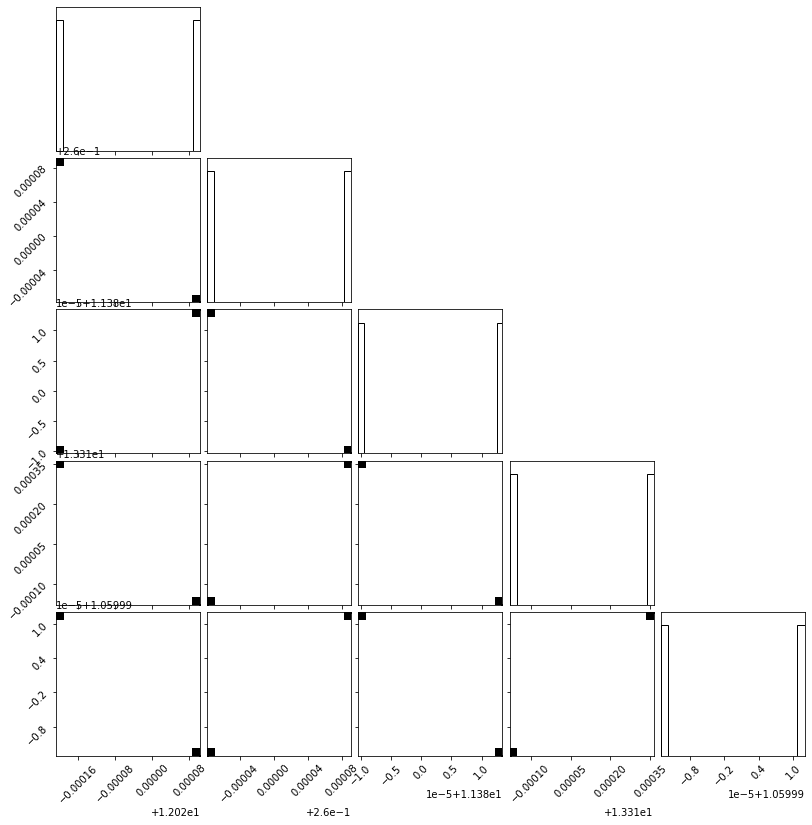

In [26]:
corner.corner(np.array(q[:,:,:]).reshape(-1,5)[:]);